<a href="https://www.kaggle.com/code/dascient/yahoo-s-top-gainers-kalman-forecasting-model?scriptVersionId=145422146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Information and market data collected from Yahoo - https://finance.yahoo.com/gainers/
## Please do not consider the recommendations below as valid. Trade at your own discretion. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install plotly
!pip install yfinance
!pip install schedule
!pip install pykalman
!pip install pandas_ta
from IPython.display import clear_output
import plotly.graph_objects as go
import schedule,warnings,time,ast
from pykalman import KalmanFilter
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil.tz import tzlocal
from rich import print, pretty
from datetime import datetime
from random import randint
from random import seed
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np
import lxml.html
import requests
import os

clear_output()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
def calculate_symbol(df):
    
    df['close'] = df['Close']
    df['low'] = df['Low']
    df['high'] = df['High']
    df['open'] = df['Open']
    
    close = df['close'][len(df)-1]
    low = df['low'][len(df)-1]

    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                      observation_matrices = [1],   # The value for Ht.
                      initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                      initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                      observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                      transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
    # Get the Kalman smoothing
    state_means, _ = kf.filter(df['close'].values)
    # Call it kf_mean
    df['kf_mean'] = np.array(state_means)
    kalman = df.kf_mean[len(df)-1]
    aboveKalman = low > kalman


    # exponential moving averages 
    ema_13 = df.ta.ema(13, append=True)[-1:].reset_index(drop=True)[0]
    ema_31 = df.ta.ema(31, append=True)[-1:].reset_index(drop=True)[0]
    #ema_125 = df.ta.ema(125, append=True)[-1:].reset_index(drop=True)[0]
    ema_crossover = ema_13 > kalman


    # lower/upper 14-day bollinger bands for mean reversion
    bbl_14 = df.ta.bbands(length=14, append=True)[['BBL_14_2.0']].tail(1).values[0][0]
    bbu_14 = df.ta.bbands(length=14, append=True)[['BBU_14_2.0']].tail(1).values[0][0]
    bband_buy = close < bbl_14
    bband_sell = close > bbu_14


    # ichimoku 9 & 26-day forecasts 
    # https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.IchimokuIndicator
    isa_9 = df.ta.ichimoku()[1]['ISA_9'].tail(1).values[0] # help(ta.ichimoku)
    isb_26 = df.ta.ichimoku()[1]['ISB_26'].tail(1).values[0]


    # archer ma 
    # https://github.com/twopirllc/pandas-ta#general
    amat = (df.ta.amat()['AMATe_LR_8_21_2'].tail(1).values[0] == 1)


    # rsi
    rsi = df.ta.rsi()[len(df)-1]
    rsi_buy = rsi < 30
    rsi_sell = rsi > 70


    # choppy
    # https://github.com/twopirllc/pandas-ta#trend-18
    try: 
        chop = "{:.2f}".format(df.ta.chop()[len(df.ta.chop())-1]) 
    except RunTimeWarning:
        chop = 0


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    # signal
    #buy = (close < isa_9) & (close < isb_26) & amat & rsi_buy & bband_buy & aboveKalman
    
    # kalman is accounted for in the ema_crossover
    buy = amat & ema_crossover# & aboveKalman

    #sell = (close > isa_9) & (close > isb_26) & ~amat & rsi_sell & bband_sell & ~aboveKalman
    
    # kalman is accounted for in the ema_crossover
    sell = ~amat & ~ema_crossover# & ~aboveKalman
    
    return df, close, isa_9, isb_26, chop, rsi, amat, ema_crossover, buy, sell, aboveKalman

# plotter
def plot(df,symbol):
    fig = go.Figure(go.Candlestick(x=df.index,
                                   open=df['open'],
                                   high=df['high'],
                                   low=df['low'],
                                   close=df['close'],
                                   name=symbol,
                                  ))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['kf_mean'], 
                             opacity=0.7, 
                             line=dict(color='purple', width=2), 
                             name='Kalman Filter'))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_13'], 
                             opacity=0.7, 
                             line=dict(color='orange', width=2), 
                             name='EMA_13'))
    
    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_31'], 
                             opacity=0.7, 
                             line=dict(color='lightblue', width=2), 
                             name='EMA_31 '))
    
    fig.update_layout(title=f'Ticker: {symbol}')
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig.show()

# Today's Top Gainers 
## Including Closing Price, Ichimoku 9 & 26 Day Spans, Choppiness, RSI, & Kalman Forecast Predictors

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: AUSAF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 0.004999999888241291

Ichimoku 9-Day Forecast: 0.00500499988811498

Ichimoku 26-Day Forecast: 0.00500499988811498

Choppiness (%): 0.00

RSI: 96.80647868331226

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

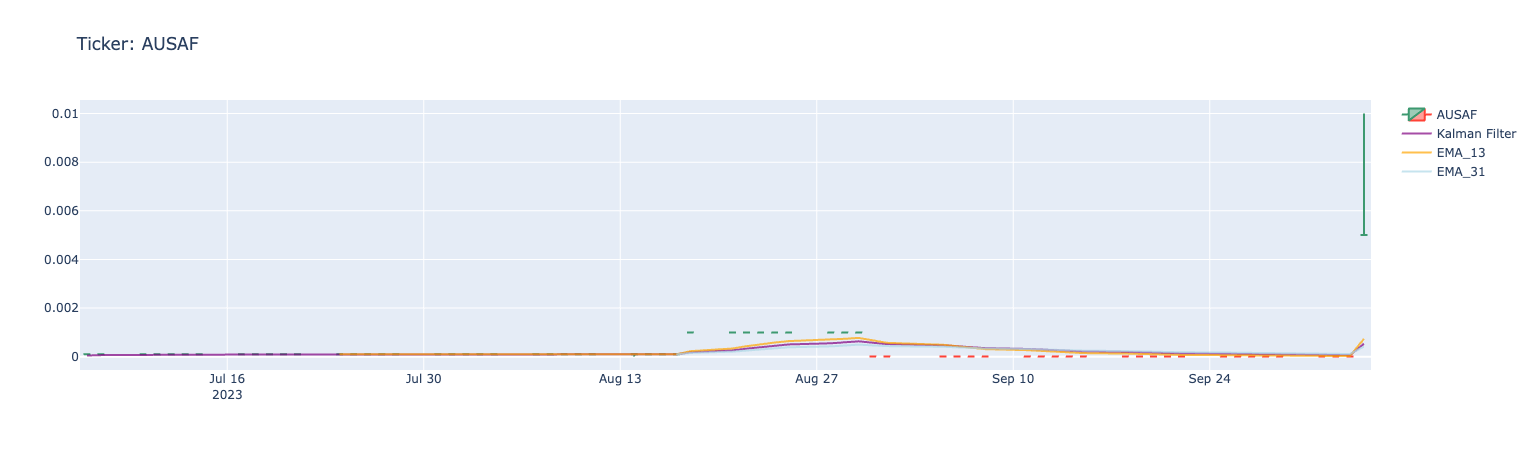

Ticker: MRTX

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 62.380001068115234

Ichimoku 9-Day Forecast: 49.355000019073486

Ichimoku 26-Day Forecast: 45.46999931335449

Choppiness (%): 19.18

RSI: 82.54515146126171

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

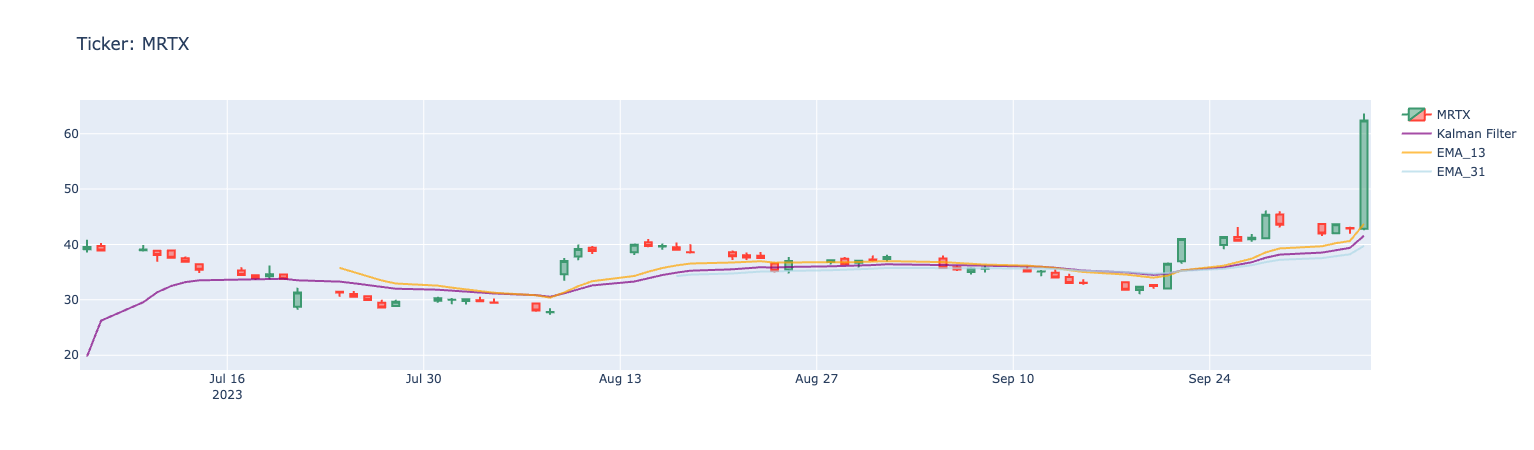

Ticker: EURN

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 17.290000915527344

Ichimoku 9-Day Forecast: 16.168749809265137

Ichimoku 26-Day Forecast: 16.47749948501587

Choppiness (%): 49.46

RSI: 56.330385424776594

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: True

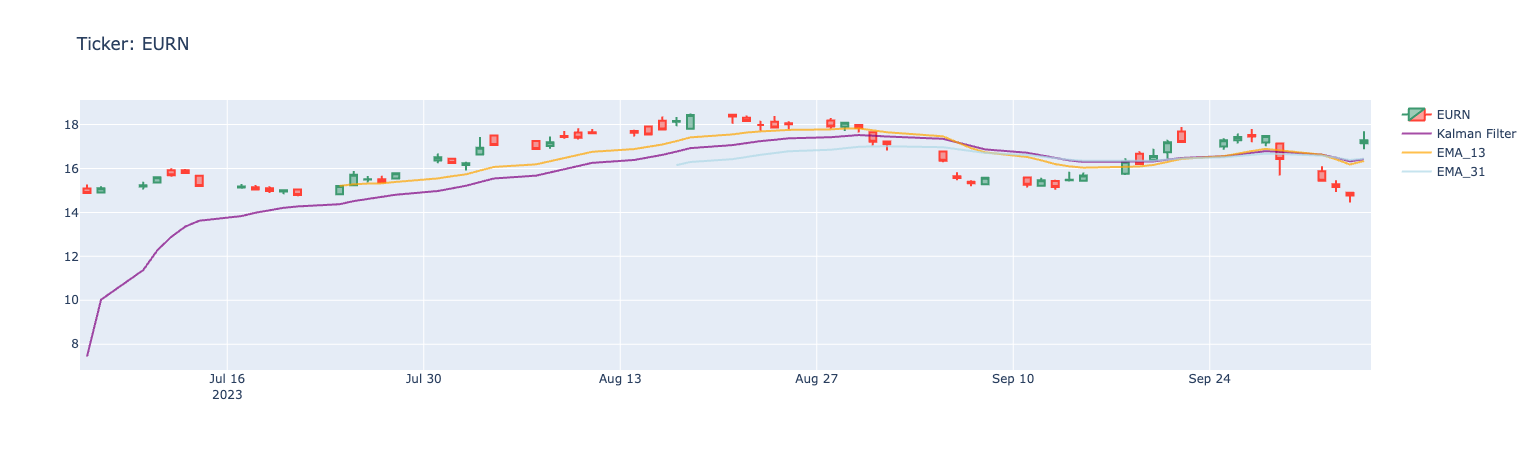

Ticker: NUVL

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 62.40999984741211

Ichimoku 9-Day Forecast: 51.500000953674316

Ichimoku 26-Day Forecast: 51.17500114440918

Choppiness (%): 37.40

RSI: 76.17645431780198

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

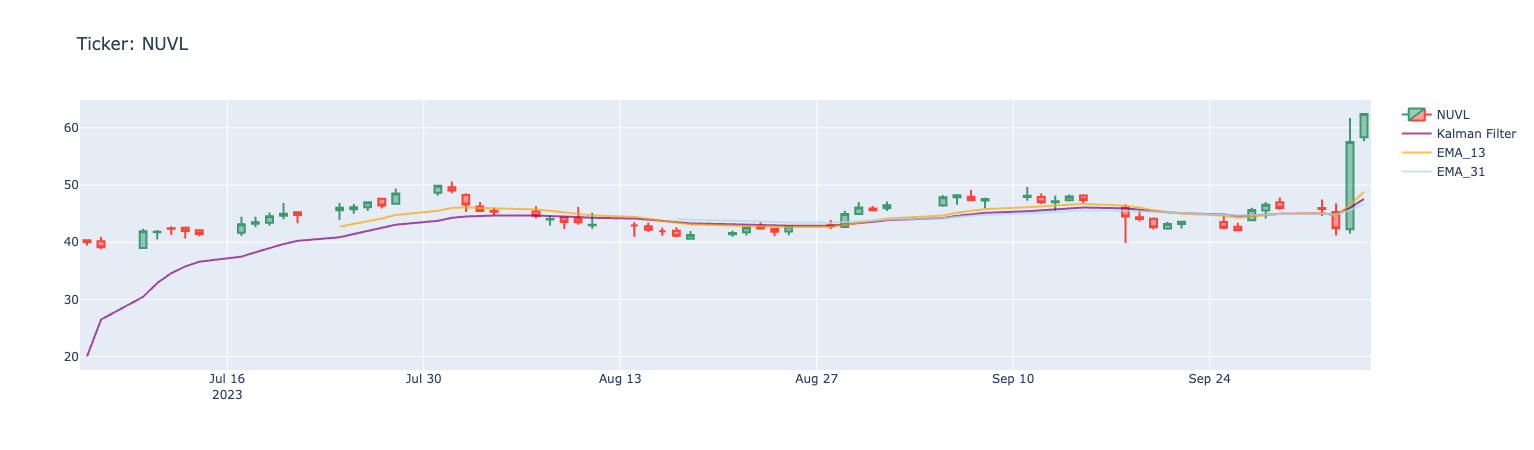

Ticker: MLTX

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 62.459999084472656

Ichimoku 9-Day Forecast: 56.3727502822876

Ichimoku 26-Day Forecast: 56.295501708984375

Choppiness (%): 47.06

RSI: 67.11812876537007

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

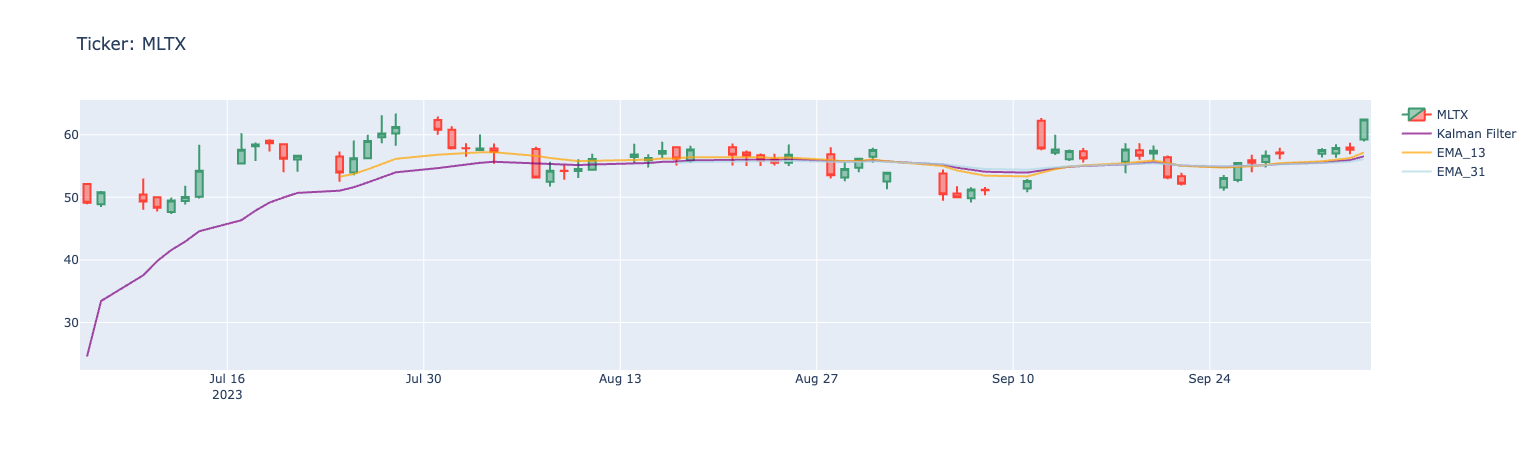

Ticker: LW

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 97.75

Ichimoku 9-Day Forecast: 95.27599716186523

Ichimoku 26-Day Forecast: 103.06100082397461

Choppiness (%): 37.82

RSI: 56.08745385866372

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: True

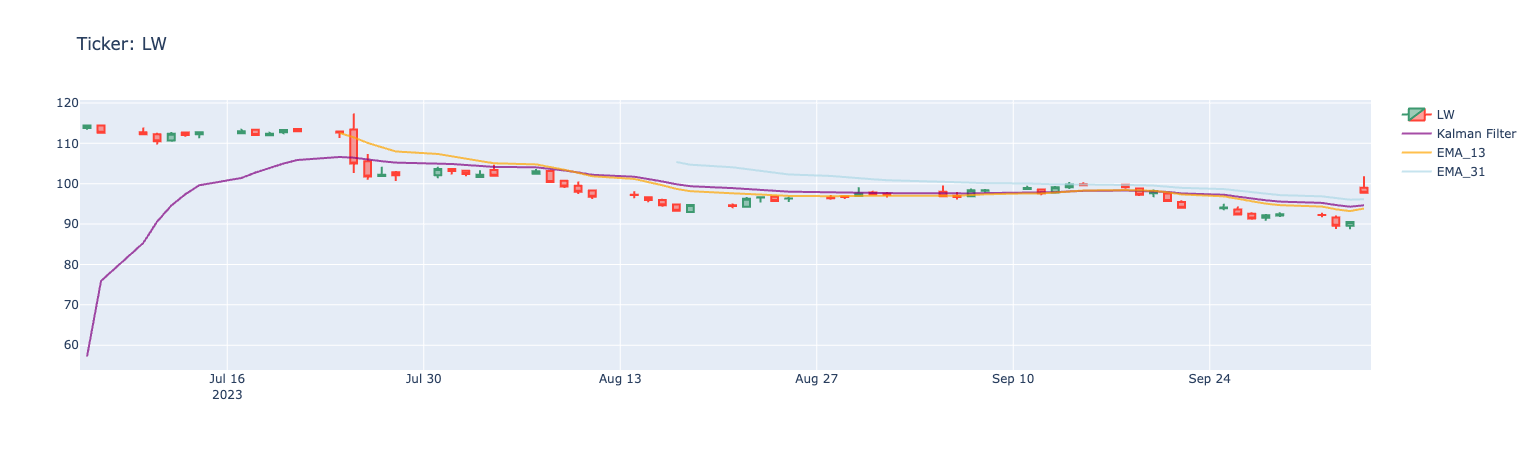

Ticker: UWMC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 5.039999961853027

Ichimoku 9-Day Forecast: 5.0274999141693115

Ichimoku 26-Day Forecast: 5.734999895095825

Choppiness (%): 37.49

RSI: 46.31804680857201

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

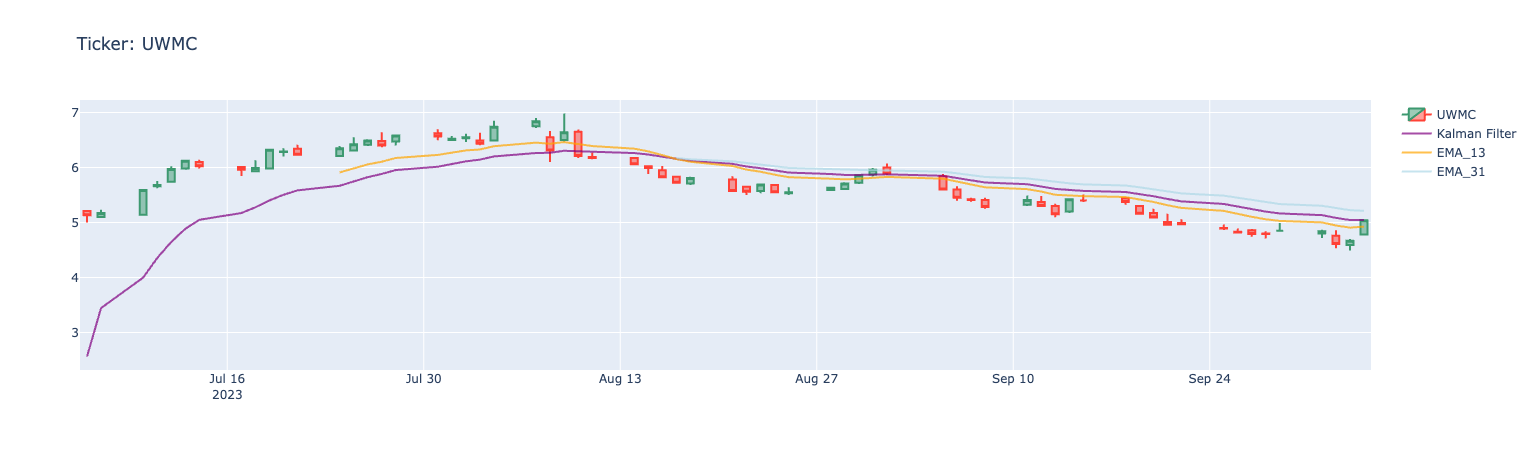

Ticker: FYBR

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 15.149999618530273

Ichimoku 9-Day Forecast: 14.914999961853027

Ichimoku 26-Day Forecast: 16.41249990463257

Choppiness (%): 53.09

RSI: 49.10133766900664

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

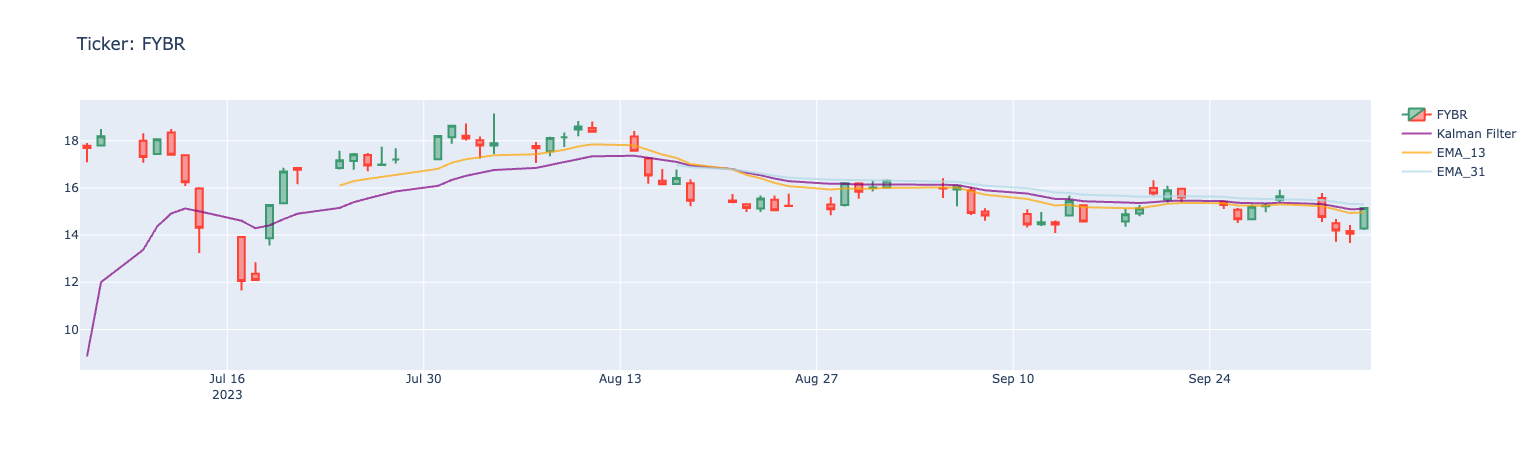

Ticker: ESMT

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 20.15999984741211

Ichimoku 9-Day Forecast: 18.59249973297119

Ichimoku 26-Day Forecast: 18.175000190734863

Choppiness (%): 33.31

RSI: 74.44864517582008

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

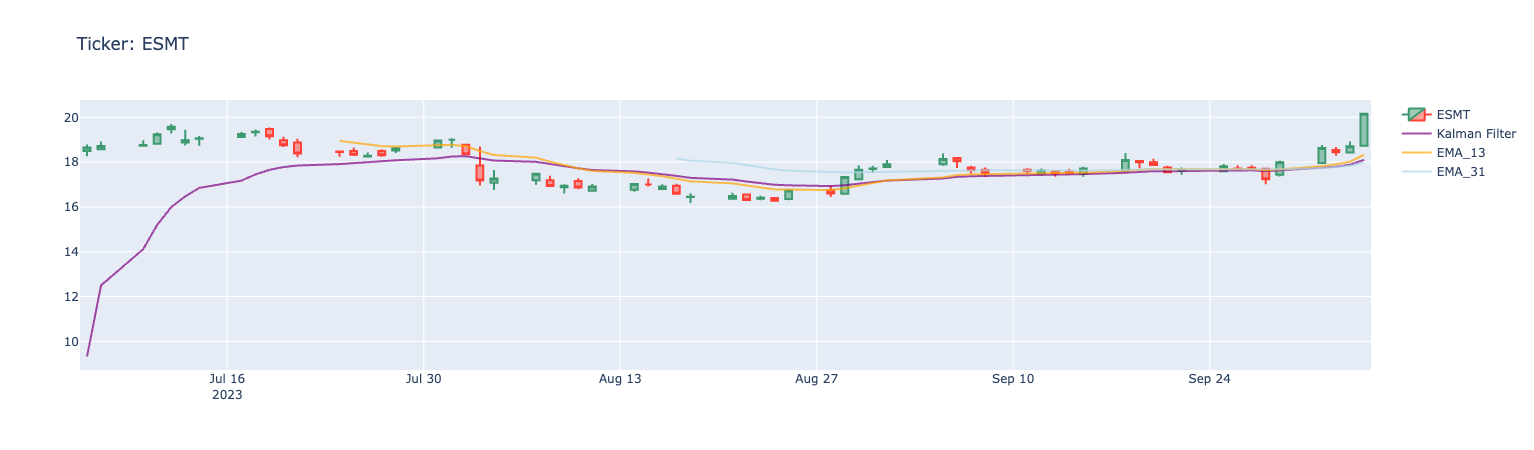

Ticker: FRO

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 18.690000534057617

Ichimoku 9-Day Forecast: 17.66000008583069

Ichimoku 26-Day Forecast: 17.075000286102295

Choppiness (%): 52.65

RSI: 60.045239020726605

Archer MA Trending: False

EMA14 > Kalman: True

Low > Kalman: False

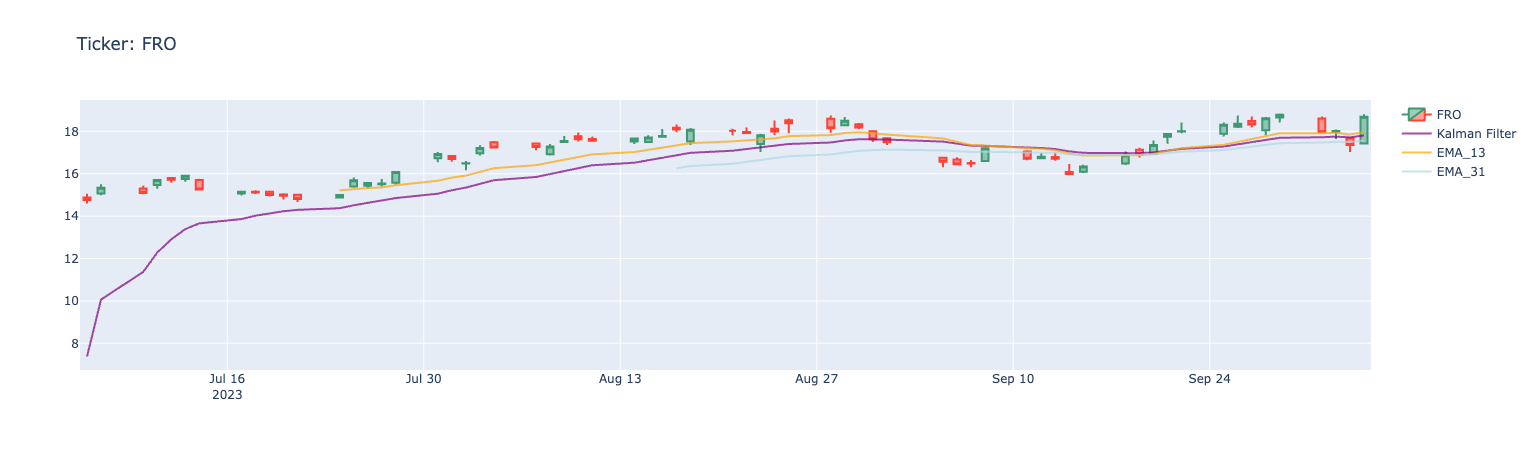

Ticker: IMVT

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 36.61000061035156

Ichimoku 9-Day Forecast: 31.844999313354492

Ichimoku 26-Day Forecast: 31.5049991607666

Choppiness (%): 28.52

RSI: 68.99642454220212

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

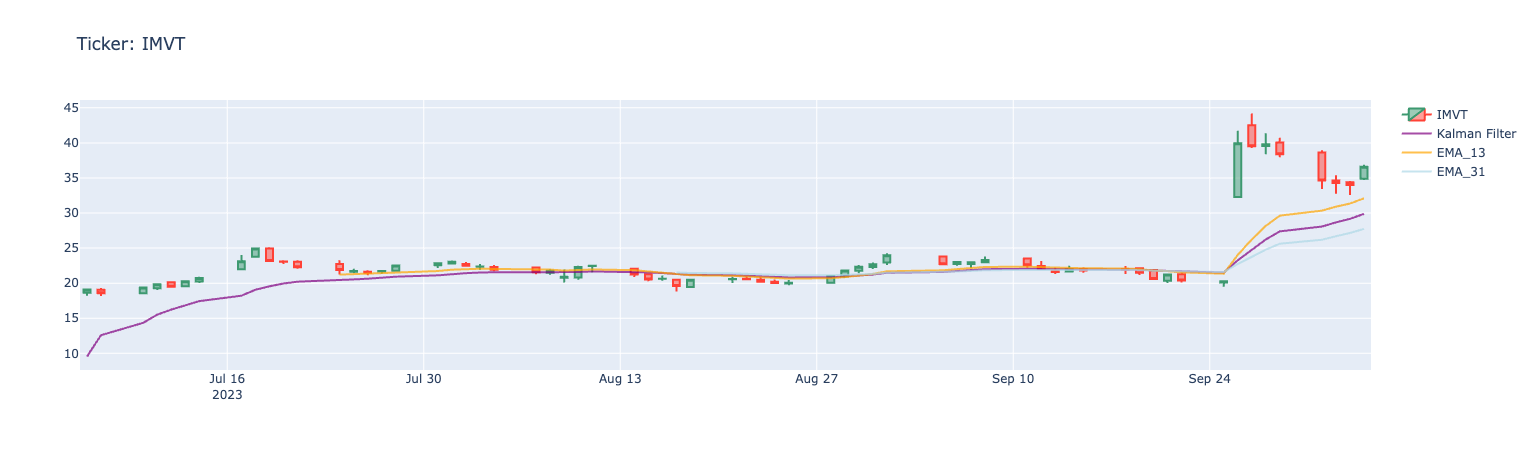

Ticker: ARWR

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 25.549999237060547

Ichimoku 9-Day Forecast: 26.360000133514404

Ichimoku 26-Day Forecast: 29.855000495910645

Choppiness (%): 40.57

RSI: 39.726498066903886

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

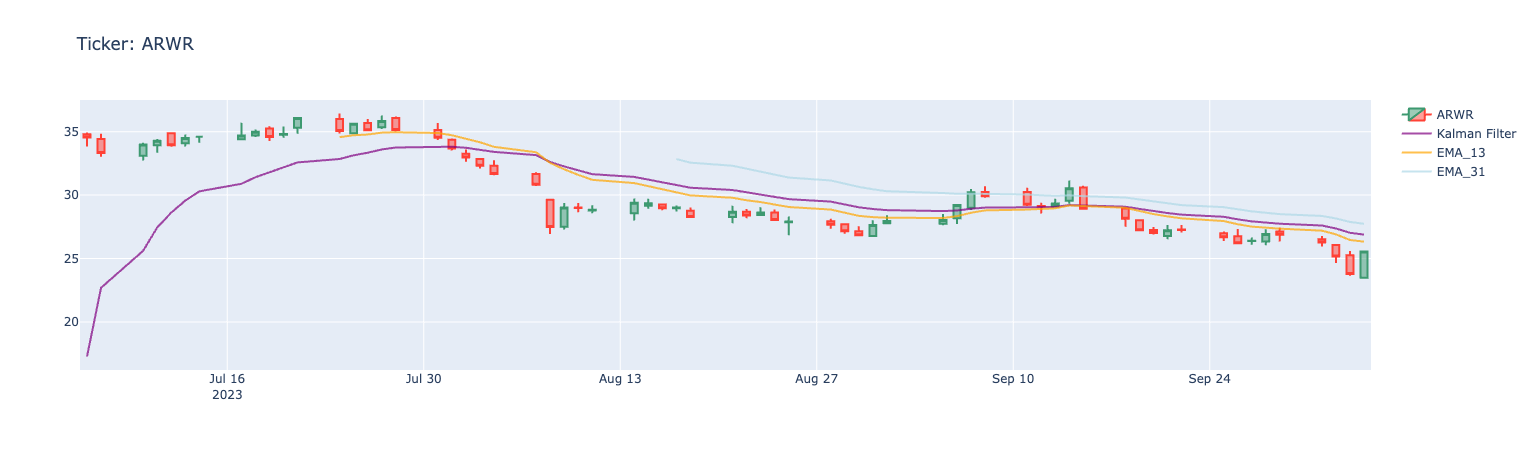

Ticker: TAC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 8.640000343322754

Ichimoku 9-Day Forecast: 8.759999990463257

Ichimoku 26-Day Forecast: 9.149999856948853

Choppiness (%): 34.37

RSI: 40.119096116613534

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

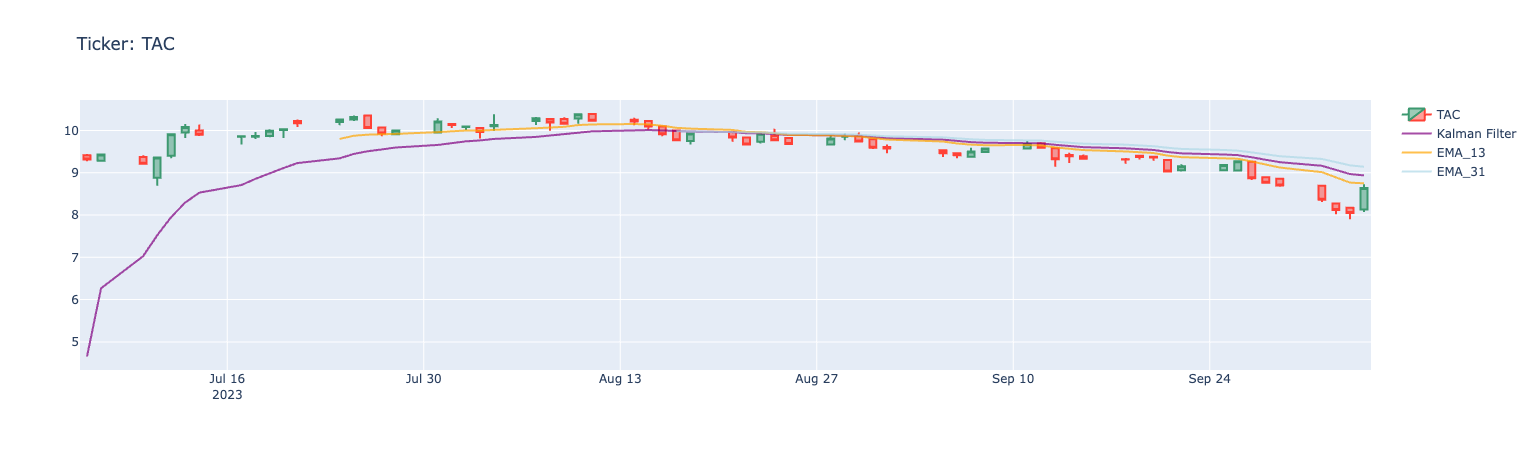

Ticker: IONS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 46.849998474121094

Ichimoku 9-Day Forecast: 44.09000110626221

Ichimoku 26-Day Forecast: 42.989999771118164

Choppiness (%): 49.62

RSI: 65.9622500356417

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: False

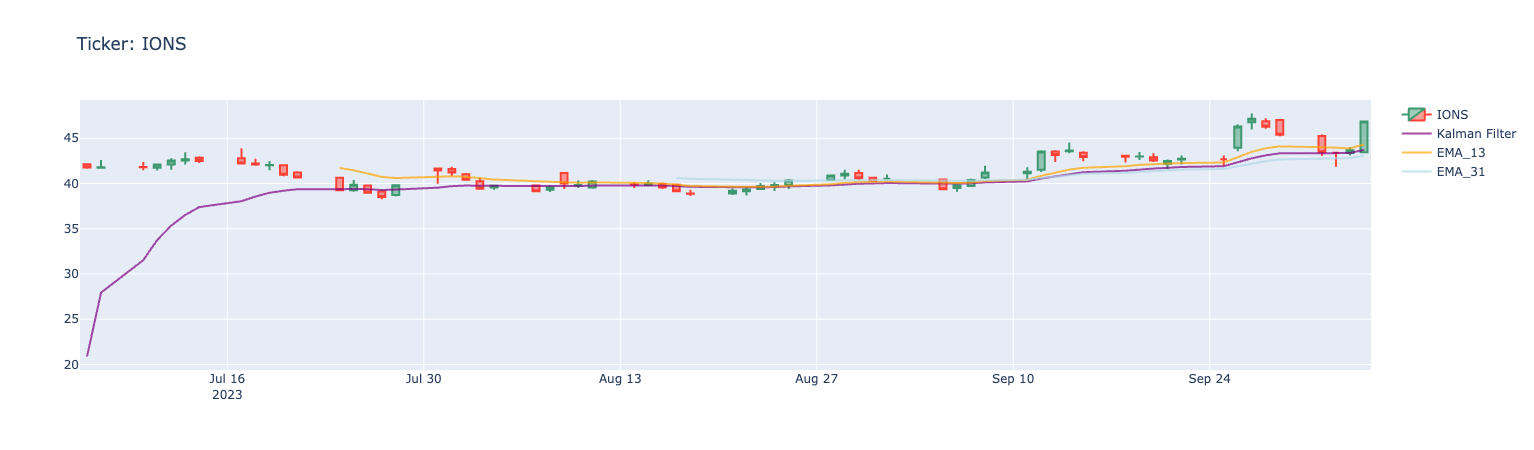

Ticker: BPMC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 49.349998474121094

Ichimoku 9-Day Forecast: 49.72874927520752

Ichimoku 26-Day Forecast: 56.97999954223633

Choppiness (%): 54.09

RSI: 46.87236289135626

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

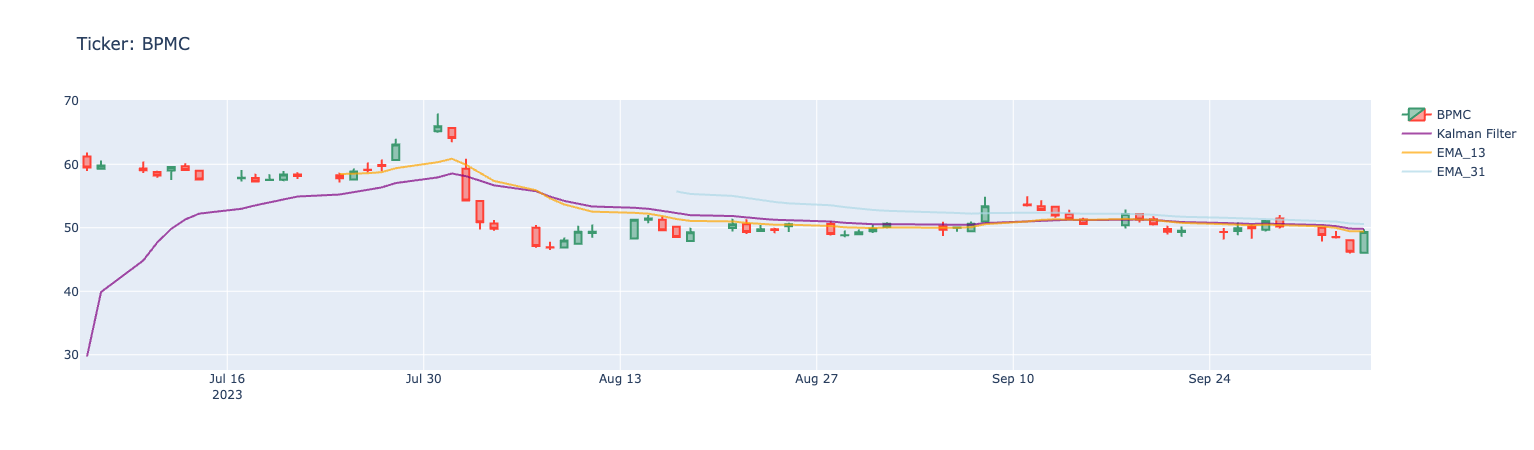

Ticker: JPXGY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 9.621999740600586

Ichimoku 9-Day Forecast: 9.241249799728394

Ichimoku 26-Day Forecast: 8.989999771118164

Choppiness (%): 46.30

RSI: 66.19242131591169

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

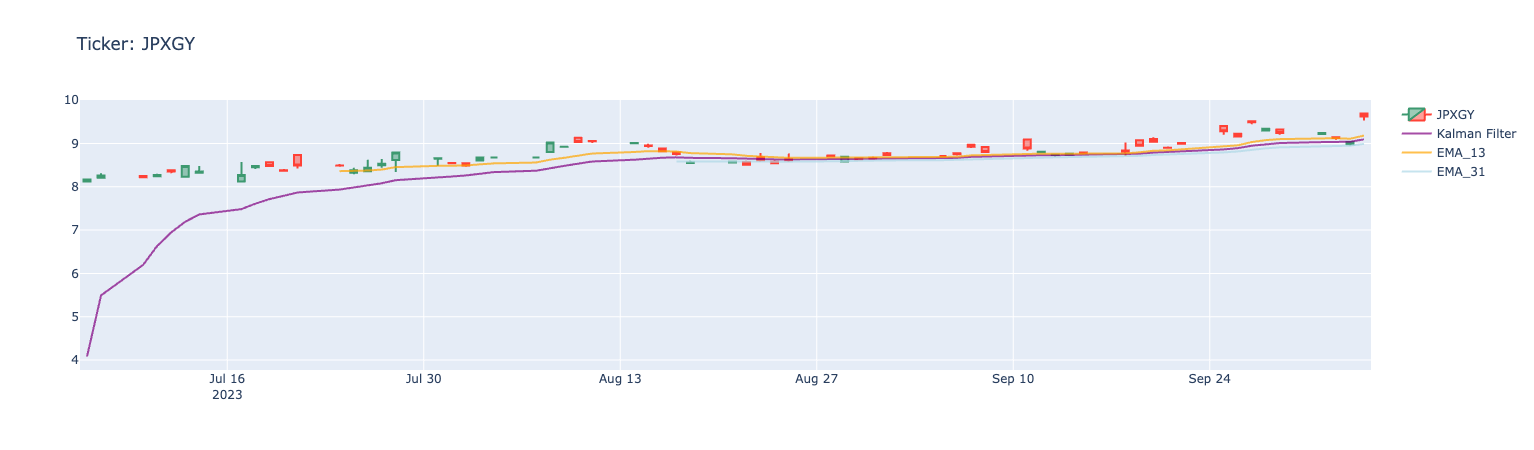

Ticker: CERE

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 21.690000534057617

Ichimoku 9-Day Forecast: 21.52874994277954

Ichimoku 26-Day Forecast: 25.270000457763672

Choppiness (%): 49.99

RSI: 47.89503634237852

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

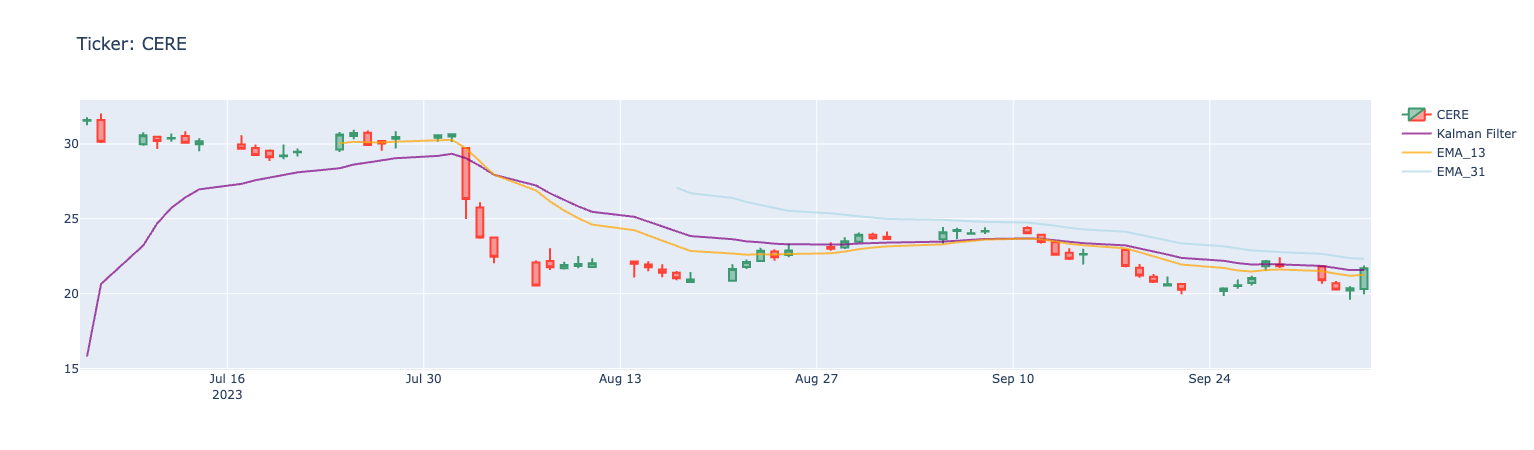

Ticker: MKTX

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 225.61000061035156

Ichimoku 9-Day Forecast: 218.33749771118164

Ichimoku 26-Day Forecast: 238.15999603271484

Choppiness (%): 47.05

RSI: 52.882488502433745

Archer MA Trending: True

EMA14 > Kalman: False

Low > Kalman: False

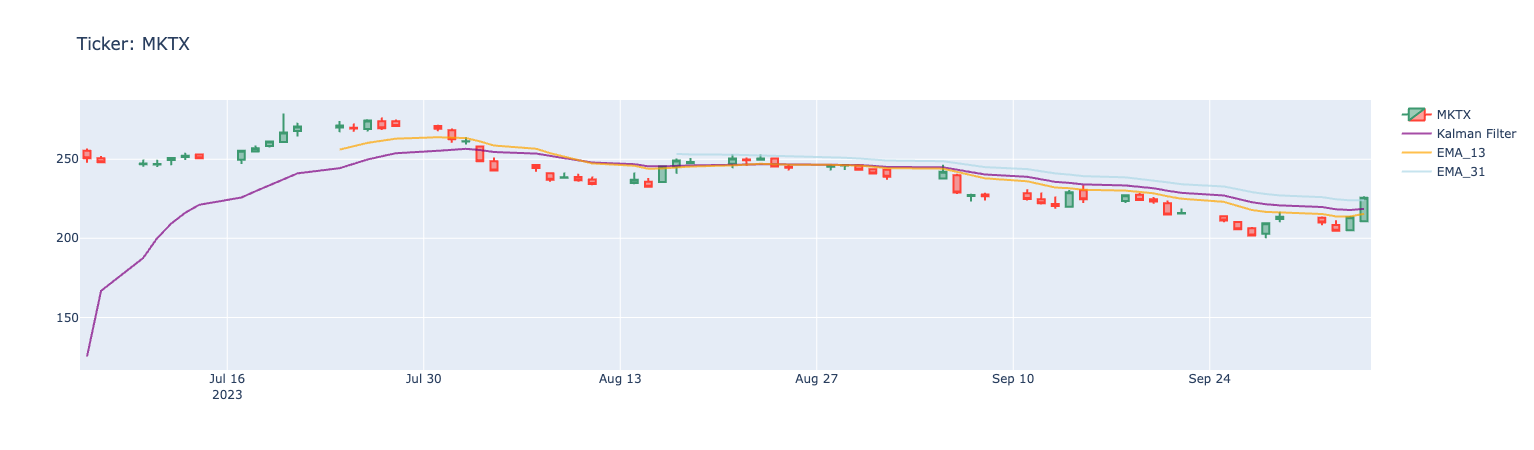

Ticker: ALNY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 178.7100067138672

Ichimoku 9-Day Forecast: 181.6974983215332

Ichimoku 26-Day Forecast: 189.73999786376953

Choppiness (%): 56.74

RSI: 46.226833906242035

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

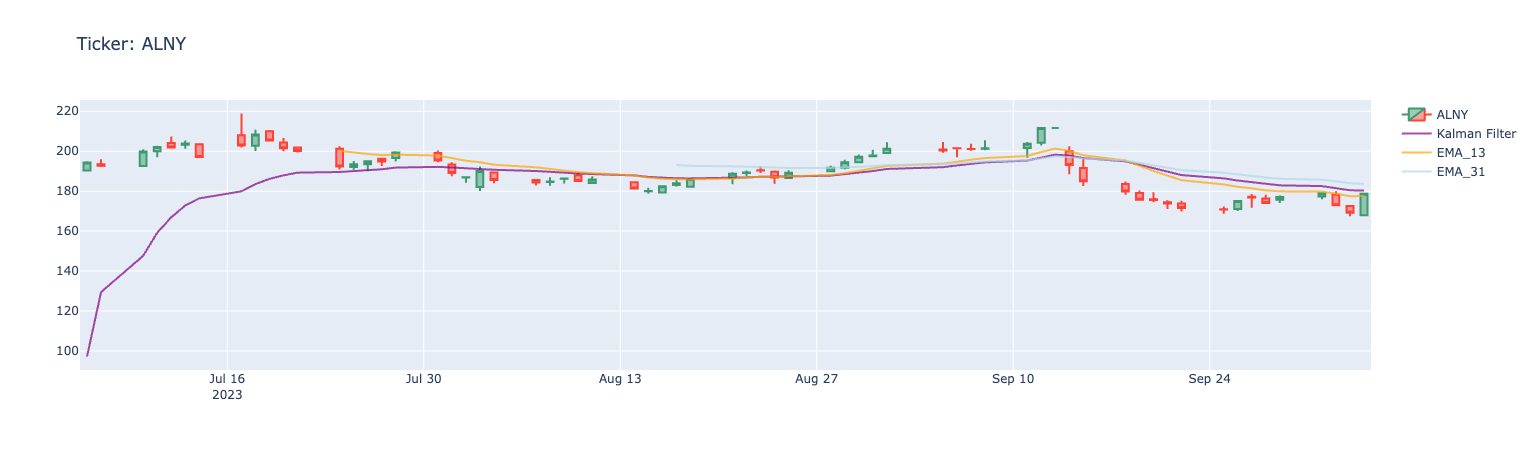

Ticker: CLS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 25.790000915527344

Ichimoku 9-Day Forecast: 23.914999961853027

Ichimoku 26-Day Forecast: 21.050000190734863

Choppiness (%): 39.35

RSI: 70.45455308608132

Archer MA Trending: True

EMA14 > Kalman: True

Low > Kalman: True

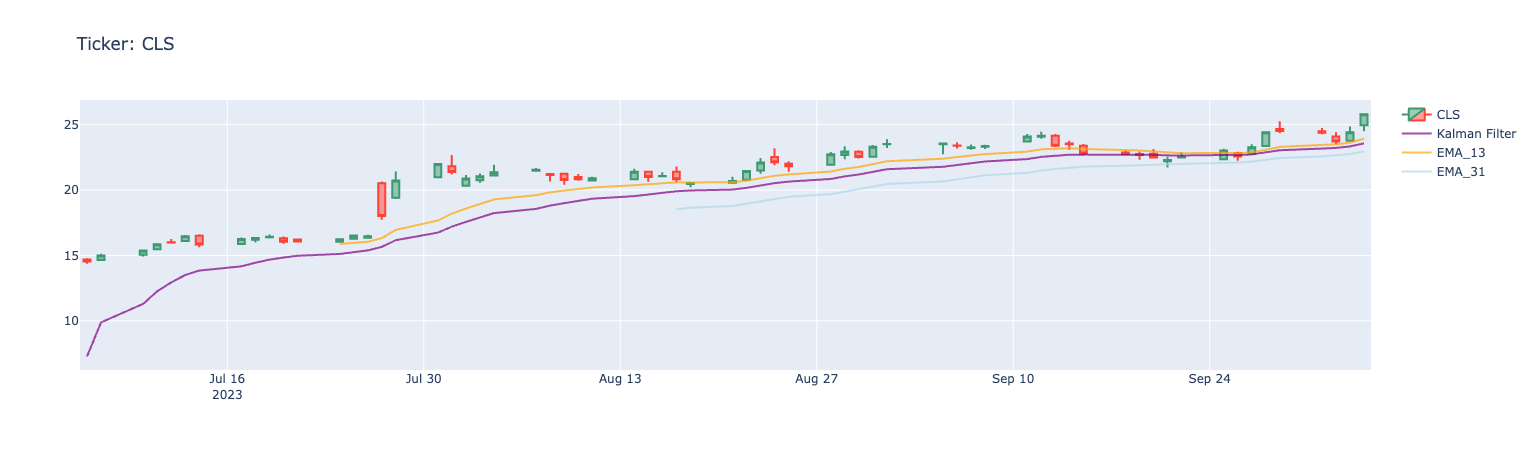

Ticker: DNA

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 1.7300000190734863

Ichimoku 9-Day Forecast: 1.9087499380111694

Ichimoku 26-Day Forecast: 2.0449999570846558

Choppiness (%): 45.94

RSI: 43.886919823564206

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

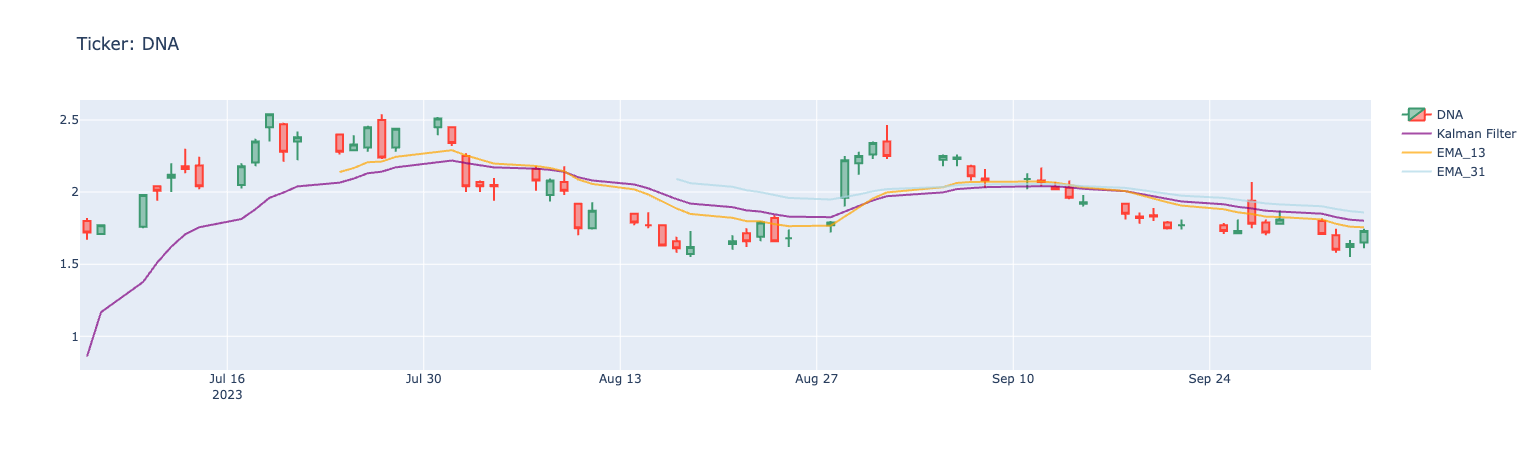

Ticker: NTLA

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 30.510000228881836

Ichimoku 9-Day Forecast: 32.165499687194824

Ichimoku 26-Day Forecast: 35.67550086975098

Choppiness (%): 35.75

RSI: 30.61346151244487

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

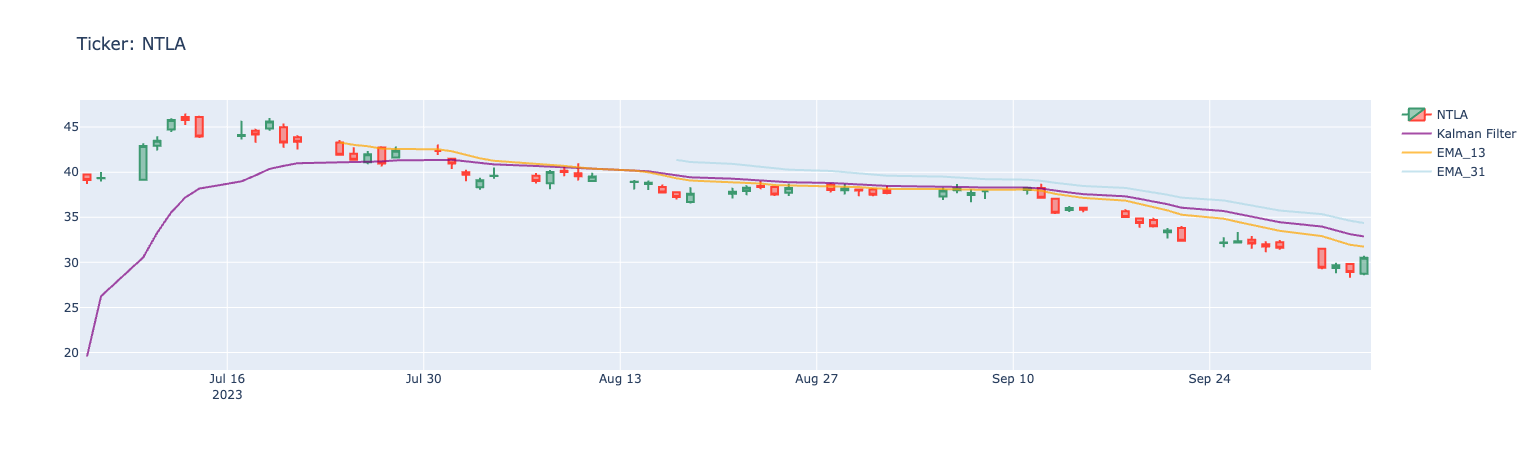

Ticker: TEO

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 4.860000133514404

Ichimoku 9-Day Forecast: 5.097499966621399

Ichimoku 26-Day Forecast: 5.474999904632568

Choppiness (%): 38.44

RSI: 39.045072446909

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

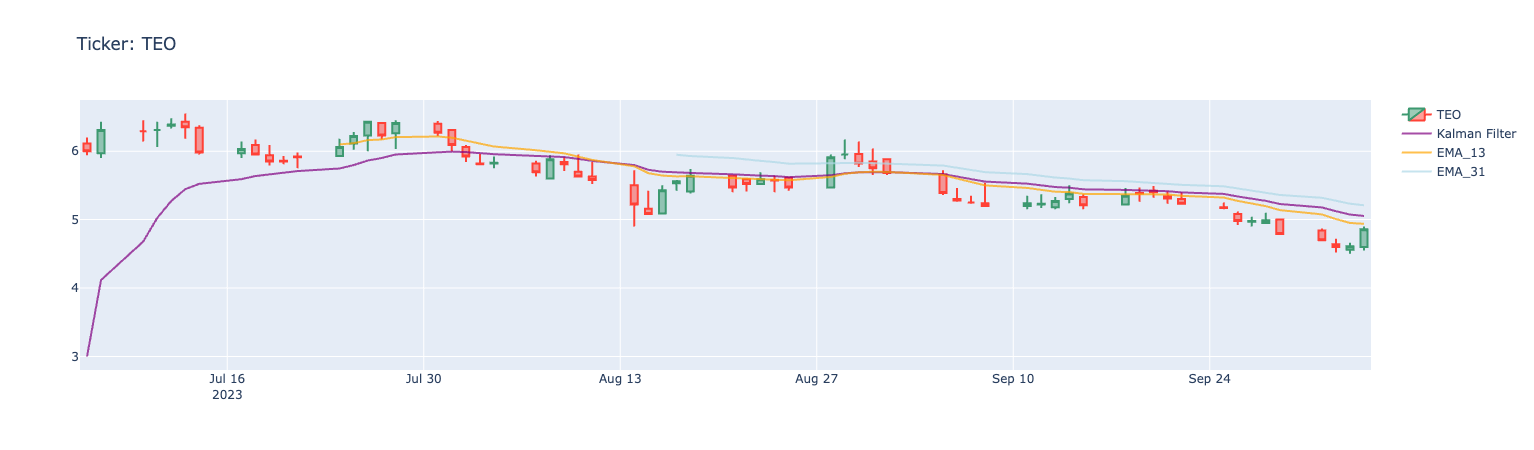

Ticker: APLS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 39.63999938964844

Ichimoku 9-Day Forecast: 41.59950065612793

Ichimoku 26-Day Forecast: 35.6850004196167

Choppiness (%): 40.84

RSI: 46.13161121164318

Archer MA Trending: False

EMA14 > Kalman: False

Low > Kalman: False

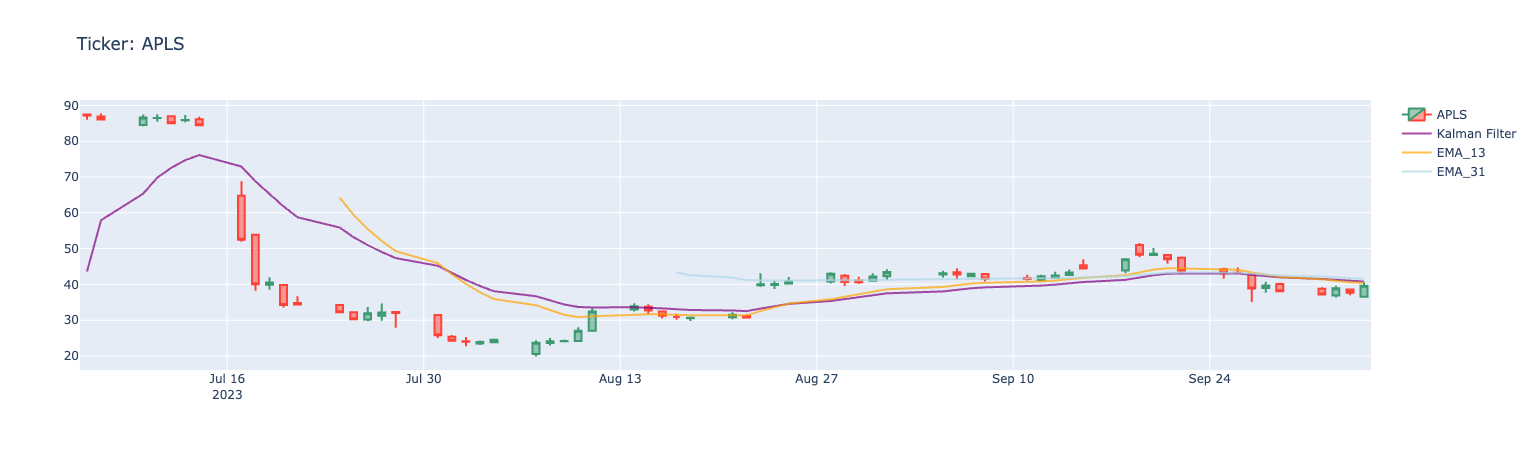

In [20]:
# Plotly within a double nested for-loop. 
# This pulls from Yahoo's Gainers first page, then implements technical indicators to output forecasts, 
# RSI, choppiness, trend archers, & other conditionals to aid in decision making.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Pull Yahoo's Top Gainers of Today - first page.

url = 'https://finance.yahoo.com/gainers'
headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
}

ytext = requests.get(url,headers=headers).text
yroot = lxml.html.fromstring(ytext)
List = []
for x in yroot.xpath('//*[@id="fin-scr-res-table"]//a'):
    List.append({"top_movers":x.attrib['href'].split("/")[-1].split("?")[0]})
List = pd.DataFrame(List)

# calculating plotter
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        calculate_symbol(v)
        print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman):',calculate_symbol(v)[8])
        print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
        print('\n\nClose:',calculate_symbol(v)[1])
        print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
        print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
        print('Choppiness (%):',calculate_symbol(v)[4])
        print('RSI:',calculate_symbol(v)[5])
        print('Archer MA Trending:',calculate_symbol(v)[6])
        print('EMA14 > Kalman:',calculate_symbol(v)[7])
        print('Low > Kalman:',calculate_symbol(v)[10])
        plot(v.tail(90),i)
    except:pass

In [21]:
# choppiness
print("Choppiness:")
help(ta.chop)

Choppiness:

Help on function chop in module pandas_ta.trend.chop:

chop(high, low, close, length=None, atr_length=None, ln=None, scalar=None, drift=None, offset=None, **kwargs)
    Choppiness Index (CHOP)
    
    The Choppiness Index was created by Australian commodity trader
    E.W. Dreiss and is designed to determine if the market is choppy
    (trading sideways) or not choppy (trading within a trend in either
    direction). Values closer to 100 implies the underlying is choppier
    whereas values closer to 0 implies the underlying is trending.
    
    Sources:
        https://www.tradingview.com/scripts/choppinessindex/
        https://www.motivewave.com/studies/choppiness_index.htm
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        HH = high.rolling(length).max()
        LL = low.rolling(length).min()
    
        ATR_SUM = SUM(ATR(drift), length)
        CHOP = scalar * (LOG10(ATR_SUM) - LOG10(HH - LL))
        CHOP /= LOG10(length)
    
    

In [ ]:
# en fin